# Find wrong bounding boxes with fastdup

In [2]:
%pip install fastdup -U --force-reinstall

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached fastdup-0.901-cp38-cp38-macosx_11_0_arm64.whl (32.8 MB)
  Using cached pandas-1.5.3-cp38-cp38-macosx_11_0_arm64.whl (10.8 MB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached certifi-2022.12.7-py3-none-any.whl (155 kB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
  Using cached numpy-1.24.2-cp38-cp38-macosx_11_0_arm64.whl (13.8 MB)
  Using cached sentry_sdk-1.16.0-py2.py3-none-any.whl (184 kB)
  Using cached Pillow-9.4.0-cp38-cp38-macosx_11_0_arm64.whl (3.0 MB)
  Using cached PyYAML-6.0-cp38-cp38-macosx_12_0_arm64.whl
  Using cached opencv_python_headless-4.5.5.64-cp37-abi3-macosx_11_0_arm64.whl (29.9 MB)
  Using cached packaging-23.0-py3-none-any.whl (42 kB)
  Using cached urllib3-1.26.

In [1]:
#download mafat traing data, extract the zip file and put the notebook one level below images/ folder

# Prepare annotation for fastdup format

In [1]:
import os
files=!ls labelTxt
files = [os.path.join('labelTxt', f) for f in files]

In [2]:
def read_annotations(f):
    with open(f, 'r') as fd:
        lines = fd.readlines()

    bounding_boxes = []

    for line in lines:
        tokens = line.split()
        x1, y1, x2, y2, x3, y3, x4, y4 = map(float, tokens[:8])
        label = tokens[8]
        bounding_box = {'annot':f , 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'x3': x3, 'y3': y3, 'x4': x4, 'y4': y4, 'label': label}
        bounding_boxes.append(bounding_box)
    return bounding_boxes

In [3]:
annot = []
for f in files:
    annot.extend(read_annotations(f))

In [4]:
import pandas as pd
df = pd.DataFrame(annot)
df['filename'] = df['annot'].apply(lambda x: x.replace('labelTxt', 'images').replace('.txt', '.tiff'))
df.head()

,annot,x1,y1,x2,y2,x3,y3,x4,y4,label,filename
0,labelTxt/10011_0_0.txt,828.32,18.09,866.47,43.15,775.87,181.07,737.72,156.01,pylon,images/10011_0_0.tiff
1,labelTxt/10011_0_0.txt,817.90,155.27,864.29,185.28,740.46,376.68,694.07,346.67,pylon,images/10011_0_0.tiff
2,labelTxt/10011_0_0.txt,834.47,685.91,875.96,712.86,782.08,857.43,740.59,830.48,pylon,images/10011_0_0.tiff
3,labelTxt/10011_0_0.txt,816.47,431.04,865.36,464.02,743.65,644.47,694.76,611.49,pylon,images/10011_0_0.tiff
4,labelTxt/10011_0_0.txt,719.43,-35.14,770.69,0.74,737.59,48.01,686.33,12.12,pylon,images/10011_0_0.tiff


In [6]:
print('total annotations', len(df))

total annotations 18113


In [7]:
df.index.name = 'index'
df[['filename', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'label']].to_csv('mafat.csv',index_label='index')

In [8]:
!head mafat.csv

index,filename,x1,y1,x2,y2,x3,y3,x4,y4,label
0,images/10011_0_0.tiff,828.32,18.09,866.47,43.15,775.87,181.07,737.72,156.01,pylon
1,images/10011_0_0.tiff,817.9,155.27,864.29,185.28,740.46,376.68,694.07,346.67,pylon
2,images/10011_0_0.tiff,834.47,685.91,875.96,712.86,782.08,857.43,740.59,830.48,pylon
3,images/10011_0_0.tiff,816.47,431.04,865.36,464.02,743.65,644.47,694.76,611.49,pylon
4,images/10011_0_0.tiff,719.43,-35.14,770.69,0.74,737.59,48.01,686.33,12.12,pylon
5,images/10011_0_0.tiff,834.54,344.16,874.27,369.97,779.75,515.51,740.02,489.7,pylon
6,images/10011_0_0.tiff,1233.3,540.65,1238.65,547.24,1233.78,551.2,1228.43,544.61,heavy_equipment
7,images/10011_0_0.tiff,817.78,769.25,866.68,801.74,746.22,983.05,697.32,950.56,pylon
8,images/10011_1280_0.tiff,701.87,421.42,755.68,465.62,744.99,478.63,691.18,434.43,pylon


# Run fastdup to crop and build a model for the crops

In [1]:
import numpy as np
import cv2

#!rm -fr output

In [2]:
import pandas as pd
import fastdup
df = pd.read_csv('mafat.csv')
df['img_filename'] = df['filename']
del df['filename']
fd = fastdup.create(input_dir='.', work_dir='output')


In [3]:
# for running advanced bounding boxes in fastdup please send email to info@databasevisual.com to get your free license. 
# Rotated bounding boxes are not supported in the free version.

In [17]:

fd.run(annotations=df, overwrite=True, license='XXXXXXXX', bounding_box='rotated', augmentation_additive_margin=15,
       verbose=False, ccthreshold=0.98)

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
2023-03-10 13:27:27 [INFO] Going to loop over dir /var/folders/4m/17tfvm293lg5scctpk1cd2940000gn/T/tmpspfm4h2r.csv
2023-03-10 13:27:27 [INFO] Found total 18113 images to run on
FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.utes 0 Features
2023-03-10 13:30:06 [INFO] Going to loop over dir /var/folders/4m/17tfvm293lg5scctpk1cd2940000gn/T/crops_input.csv
2023-03-10 13:30:06 [INFO] Found total 18113 images to run on
2023-03-10 13:30:28 [INFO] Found total 18113 images to run onimated: 0 Minutes 0 Features
2023-03-10 13:30:32 [INFO] 3317) Finished write_index() NN model
2023-03-10 13:30:32 [INFO] Stored nn model index file output/nnf.index
2023-03-10 13:30:33 [INFO] Total time took 26972 ms
2023-03-10 13:30:33 [INFO] Found a total of 12 fully identical images (d>0.990), which are 0.02 %
2023-03-10 13:30:33 [INFO] Found a total of 573 nearly identical images(d>0.980), which are 1.05 %
2023-0

# Find suspected wrong bounding boxes

From - crop image name
To - similar images
where the labels are not matching

large_vehicle


100%|█████████████████████████████████████████| 87/87 [00:00<00:00, 596.24it/s]

Finished OK. Components are stored as image files output/galleries/components_[index].jpg


Stored components visual view in  output/galleries/components.html
Execution time in seconds 2.5



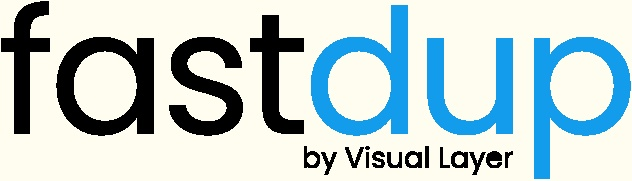
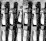
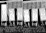
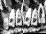
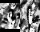
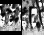
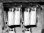
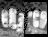
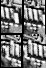
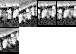
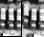
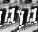
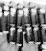
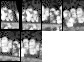
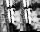
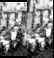
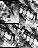
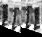
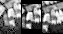
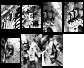
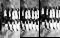
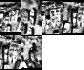
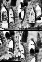
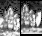
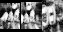
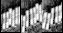
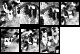
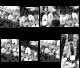
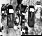
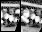
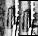
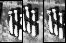
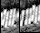
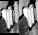
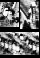
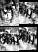
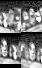
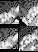
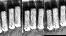
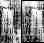

In [4]:
fd.vis.component_gallery(load_crops=True,enhance_image=True,keep_aspect_ratio=True,slice='diff',  num_images=100, save_artifacts=True)

In [9]:
# Looking at the raw cluster to link back cluster name to to file

In [6]:
df = pd.read_csv('output/galleries/components.csv')

In [7]:
df.head()

,Unnamed: 0,component_id,files,label,distance,size,len,avg_metric
0,11168,11168,"['crops/images4426_3840_6400.tiff_496_794_505_787_527_818_518_825.jpg', 'crops/images4426_3840_6400.tiff_490_799_499_793_524_827_515_834.jpg']","['small_vessel', 'large_vessel']",0.9826,"[1458, 1508]",2,1483.0
1,3030,3030,"['crops/images13111_2560_2560.tiff_293_732_300_730_315_771_308_774.jpg', 'crops/images13111_2560_2560.tiff_288_733_296_731_311_773_303_776.jpg']","['large_vessel', 'large_vessel']",0.9833,"[1320, 1403]",2,1361.5
2,497,497,"['crops/images10781_5120_5120.tiff_185_107_193_104_203_139_195_141.jpg', 'crops/images10781_5120_5120.tiff_183_192_191_190_201_225_193_227.jpg']","['large_vehicle', 'large_vehicle']",0.9851,"[1200, 1224]",2,1212.0
3,10170,10170,"['crops/images3131_5120_2560.tiff_542_487_548_483_567_514_561_518.jpg', 'crops/images3131_5120_2560.tiff_549_484_556_481_574_511_568_515.jpg']","['bus', 'large_vehicle']",0.9834,"[1173, 1173]",2,1173.0
4,6707,6707,"['crops/images16989_6400_2560.tiff_913_52_920_52_918_84_911_84.jpg', 'crops/images16989_6400_2560.tiff_906_52_913_52_910_86_903_86.jpg']","['large_vehicle', 'large_vehicle']",0.9847,"[1056, 1100]",2,1078.0
